In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.tree import DecisionTreeRegressor
import pandas as pd
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Loading and Preparing the Data

In [79]:
import os
import pandas as pd
import re

def loadData(directory):
    # create an empty list to store the loaded dataframes
    dataframes = []
    # Load the QuestionnaireIB.csv file
    questionnaire_ib = pd.read_csv('QuestionnaireIB.csv', encoding='ISO-8859-1')
    
    # Specify the columns for interpolation
    columns_to_interpolate = ['Gaze point X', 'Gaze point Y', 'Gaze point left X', 'Gaze point left Y', 
                              'Gaze point right X', 'Gaze point right Y', 'Gaze direction left X', 
                              'Gaze direction left Y', 'Gaze direction left Z', 'Gaze direction right X', 
                              'Gaze direction right Y', 'Gaze direction right Z']
    
    # Columns to check duplicates
    columns_to_check = ['Participant name', 'Eye movement type', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right']

    # loop through all files in the directory and load csv files with "dataset_III" in their name
    for filename in os.listdir(directory):
        if "dataset_II_" in filename and filename.endswith(".csv"):
            filepath = os.path.join(directory, filename)
            df = pd.read_csv(filepath)
            df.drop('Participant name', axis=1, inplace=True)
            # Extract trial number from the filename
            trial = int(filename.split('_trial_')[1].split('.')[0])
            pattern = r"participant_(\d+)_trial"
            match = re.search(pattern, filename)

            if match:
                participant = match.group(1)
            else:
                print("Participant number not found in filename.")
            # Add 'Trial' column to the dataframe and fill it with trial number
            df['Trial'] = trial
            df['Participant name'] = 'Participant'+participant
            df = pd.merge(df, questionnaire_ib[['Participant name','Total Score extended']], on='Participant name', how='left')
           
            for col in columns_to_interpolate:
                # Use interpolate() method with cubic interpolation for NaN values
                df[col] = df[col].interpolate(method='cubic')
                # Use fillna() method to fill remaining NaN values with original values

            df.fillna(method='backfill', inplace=True)
            df.fillna(method='ffill', inplace=True)

            # Replace , with . only for object type columns
            obj_cols = df.select_dtypes(include=['object']).columns

            # Loop over the columns and try to convert to numeric data type
            for col in obj_cols:
                try:
                    df[col] = pd.to_numeric(df[col].str.replace(',', '.'))
                except ValueError:
                    # If the conversion fails, do nothing
                    pass
                if df[col].apply(lambda x: str(x).isnumeric()).all():
                    df[col] = pd.to_numeric(df[col], errors='coerce')
            # Drop exact duplicate rows based on specified columns
            df.drop_duplicates(subset=columns_to_check, keep='first', inplace=True)

            # Reset index
            df.reset_index(drop=True, inplace=True)
            df = df.drop(columns=['Unnamed: 0'])
            dataframes.append(df)

    # concatenate all dataframes into one dataframe
    all_data = pd.concat(dataframes, ignore_index=True)

    # print the shape of the resulting dataframe
    print("Shape of the loaded data:", all_data.shape)
    return all_data

all_data = loadData("EyeT/EyeT")
df = all_data.copy()

Shape of the loaded data: (370332, 72)


Merging and using dataset II(explaination and evaluation for this selection at the end). Also, we are checking for duplicates on 'Participant name', 'Recording duration', 'Gaze event duration', 'Pupil diameter left', 'Pupil diameter right' column and dropping duplicate rows and the column **'Unnamed: 0'** as it is unecessary. Furthermore, we are replacing the ',' with '.' to make the columns numerical. Also, changing the dataype of columns to **'float'** that are actually numbers or scalar type but the dataype is currently 'object'. We are doing this so we can use these for correlation and PCA etc and we won't loose meaningful information.

Moreover, merging the **Total Score extended** of **Questionnaire IB**. We will be using the Total Score Extended as our output variable and we are using this as it includes the score of all the questions from the original questionnaire, plus additional questions.

# Exploring the data

In [80]:
all_data = df.copy()
all_data

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,...,Eye movement type index,Fixation point X,Fixation point Y,Fixation point X (MCSnorm),Fixation point Y (MCSnorm),Mouse position X,Mouse position Y,Trial,Participant name,Total Score extended
0,4394847,2575955327,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,5.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,Participant10,100
1,4400762,2575961242,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,16.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,Participant10,100
2,4425765,2575986245,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,6.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,Participant10,100
3,4434123,2575994603,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,17.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,Participant10,100
4,4450780,2576011260,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,13.0,1710.0,1083.0,0.5457,0.3710,-405.0,1017.0,0,Participant10,100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
370327,65837190,1666203458708,Eye Tracker,Participant0060,20.09.2021,Recording4,20.09.2021,20.09.2021,16:36:55.737,14:36:55.737,...,161.0,738.0,501.0,0.3221,0.4638,-425.0,850.0,3,Participant60,80
370328,65862189,1666203483707,Eye Tracker,Participant0060,20.09.2021,Recording4,20.09.2021,20.09.2021,16:36:55.737,14:36:55.737,...,161.0,738.0,501.0,0.3221,0.4638,-425.0,850.0,3,Participant60,80
370329,65887160,1666203508678,Eye Tracker,Participant0060,20.09.2021,Recording4,20.09.2021,20.09.2021,16:36:55.737,14:36:55.737,...,161.0,738.0,501.0,0.3221,0.4638,-425.0,850.0,3,Participant60,80
370330,65912168,1666203533686,Eye Tracker,Participant0060,20.09.2021,Recording4,20.09.2021,20.09.2021,16:36:55.737,14:36:55.737,...,161.0,738.0,501.0,0.3221,0.4638,-425.0,850.0,3,Participant60,80


In [81]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print(all_data.dtypes)

Recording timestamp                      int64
Computer timestamp                       int64
Sensor                                  object
Project name                            object
Export date                             object
Recording name                          object
Recording date                          object
Recording date UTC                      object
Recording start time                    object
Recording start time UTC                object
Recording duration                       int64
Timeline name                           object
Recording Fixation filter name          object
Recording software version              object
Recording resolution height              int64
Recording resolution width               int64
Recording monitor latency              float64
Eyetracker timestamp                   float64
Event                                   object
Event value                             object
Gaze point X                           float64
Gaze point Y 

Checking for data types after the data has been loaded, doing this to ensure no meaningful column is left with unexpected datatype.

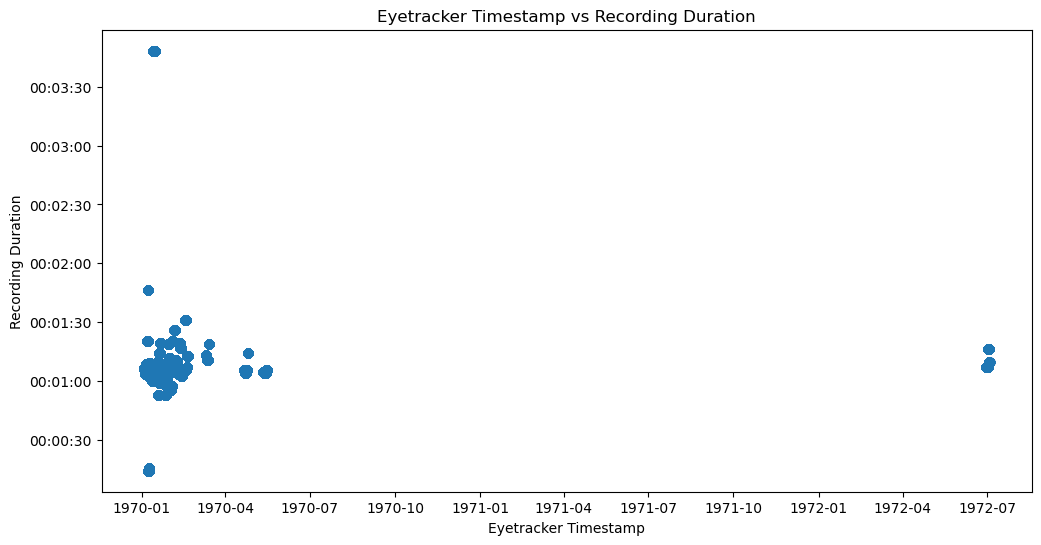

In [82]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Create a copy of the original dataset
all_data_copy = all_data.copy()

# Convert 'Eyetracker timestamp' column to datetime
all_data_copy['Eyetracker timestamp'] = pd.to_datetime(all_data_copy['Eyetracker timestamp'], unit='ms')

# Convert 'Recording duration' column to datetime in milliseconds
all_data_copy['Recording duration'] = pd.to_datetime(all_data_copy['Recording duration'], unit='ms')

# Set figure size
plt.figure(figsize=(12, 6)) # Width = 12 inches, Height = 6 inches

# Create scatter plot
plt.scatter(all_data_copy['Eyetracker timestamp'], all_data_copy['Recording duration'])

# Set plot labels and title
plt.xlabel('Eyetracker Timestamp')
plt.ylabel('Recording Duration')
plt.title('Eyetracker Timestamp vs Recording Duration')

# Show the plot
plt.show()


This plot shows the Recording duration was majorly between 30 sec to 1 minute 30 swecond.

In [83]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')


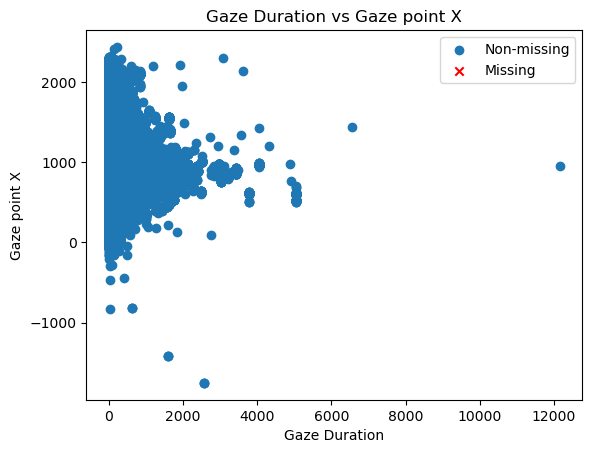

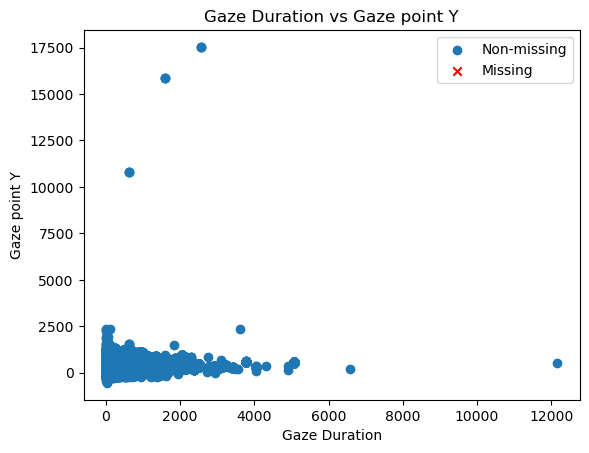

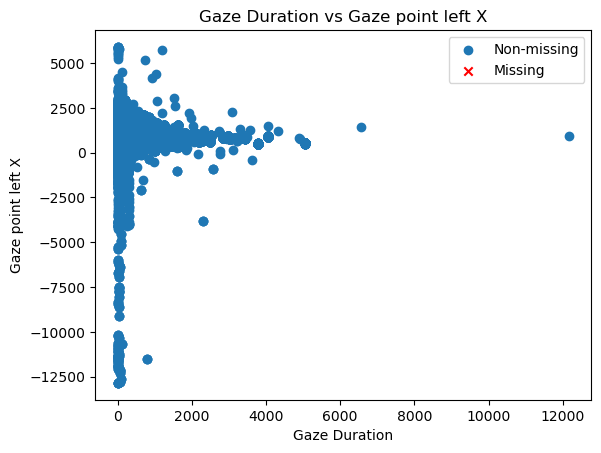

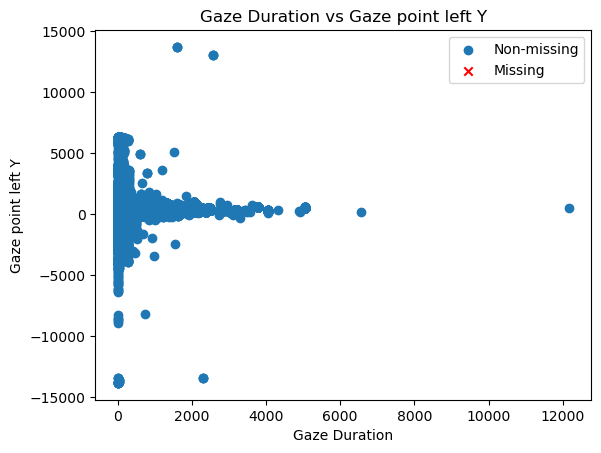

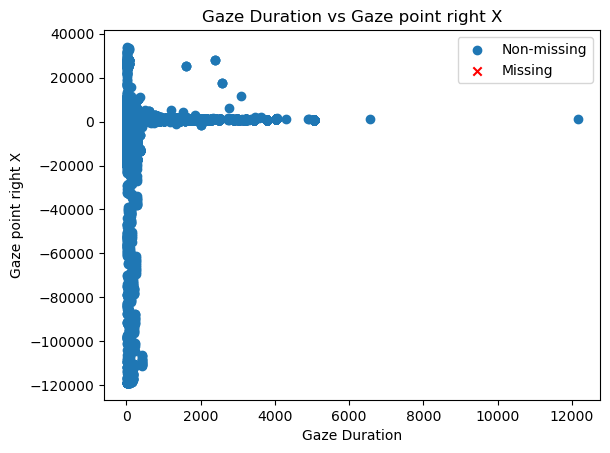

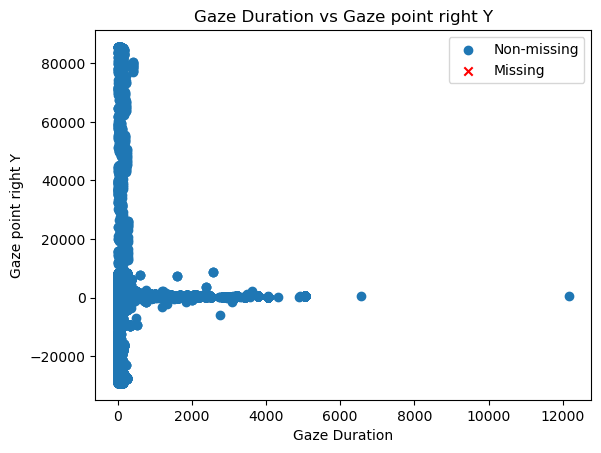

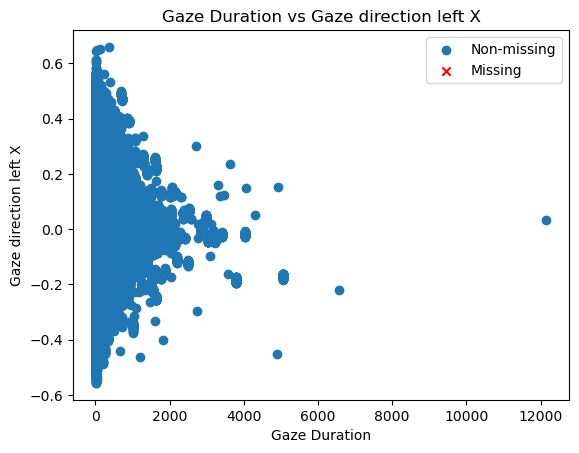

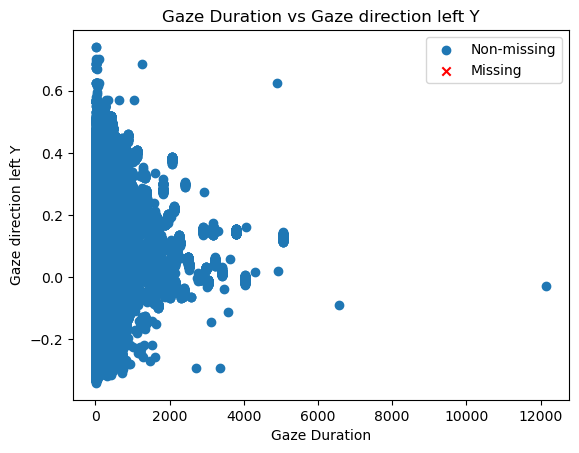

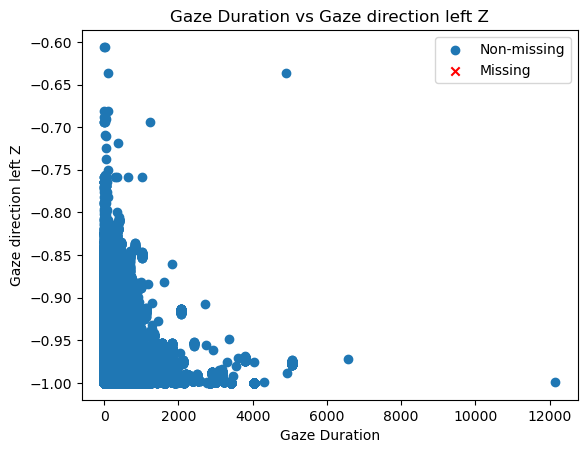

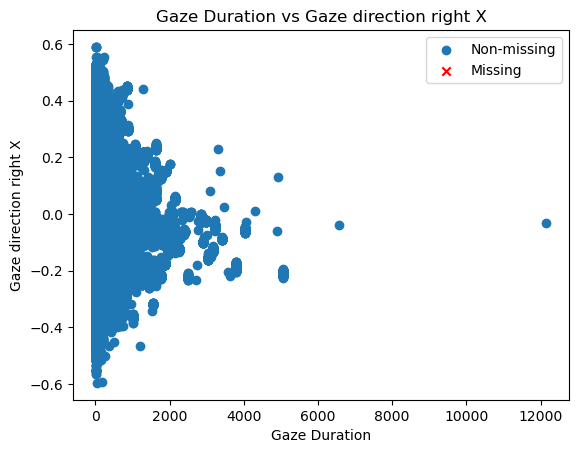

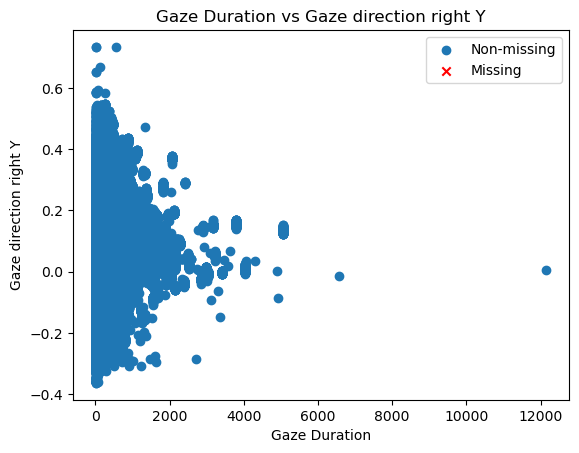

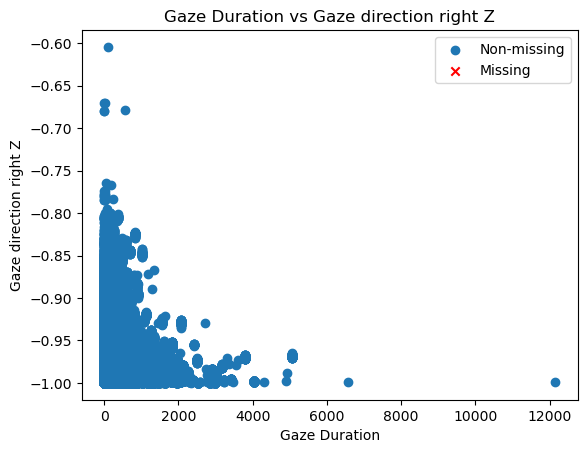

In [84]:
# Import libraries
import matplotlib.pyplot as plt

# Specify the columns for interpolation
columns_to_interpolate = ['Gaze point X', 'Gaze point Y', 'Gaze point left X', 'Gaze point left Y', 
                          'Gaze point right X', 'Gaze point right Y', 'Gaze direction left X', 
                          'Gaze direction left Y', 'Gaze direction left Z', 'Gaze direction right X', 
                          'Gaze direction right Y', 'Gaze direction right Z']

# Specify the gaze duration column
gaze_duration_column = 'Gaze event duration'

# Loop through each column and create scatter plots and line plots
for col in columns_to_interpolate:
    # Filter rows with missing values in the column
    missing_mask = all_data[col].isna()
    
    # Extract gaze duration for missing and non-missing values
    gaze_duration_missing = all_data.loc[missing_mask, gaze_duration_column]
    gaze_duration_non_missing = all_data.loc[~missing_mask, gaze_duration_column]
    
    # Extract column values for missing and non-missing values
    col_values_missing = all_data.loc[missing_mask, col]
    col_values_non_missing = all_data.loc[~missing_mask, col]
    
    # Create scatter plot of gaze duration vs column values
    plt.figure()
    plt.scatter(gaze_duration_non_missing, col_values_non_missing, label='Non-missing')
    plt.scatter(gaze_duration_missing, col_values_missing, label='Missing', color='red', marker='x')
    plt.xlabel('Gaze Duration')
    plt.ylabel(col)
    plt.title(f'Gaze Duration vs {col}')
    plt.legend()
    plt.show()



The above relationship shows the relationship of gaze direction and gaze point with gaze duration. We can observe that data is mostly skewed and in some cases where it is asymmetrical or triangle like shape, the data is decreasing after some duration. This shows that data is actually non linear

array([[<AxesSubplot:title={'center':'Recording timestamp'}>,
        <AxesSubplot:title={'center':'Computer timestamp'}>,
        <AxesSubplot:title={'center':'Recording duration'}>,
        <AxesSubplot:title={'center':'Recording resolution height'}>,
        <AxesSubplot:title={'center':'Recording resolution width'}>,
        <AxesSubplot:title={'center':'Recording monitor latency'}>,
        <AxesSubplot:title={'center':'Eyetracker timestamp'}>],
       [<AxesSubplot:title={'center':'Gaze point X'}>,
        <AxesSubplot:title={'center':'Gaze point Y'}>,
        <AxesSubplot:title={'center':'Gaze point left X'}>,
        <AxesSubplot:title={'center':'Gaze point left Y'}>,
        <AxesSubplot:title={'center':'Gaze point right X'}>,
        <AxesSubplot:title={'center':'Gaze point right Y'}>,
        <AxesSubplot:title={'center':'Gaze direction left X'}>],
       [<AxesSubplot:title={'center':'Gaze direction left Y'}>,
        <AxesSubplot:title={'center':'Gaze direction left Z'}>,


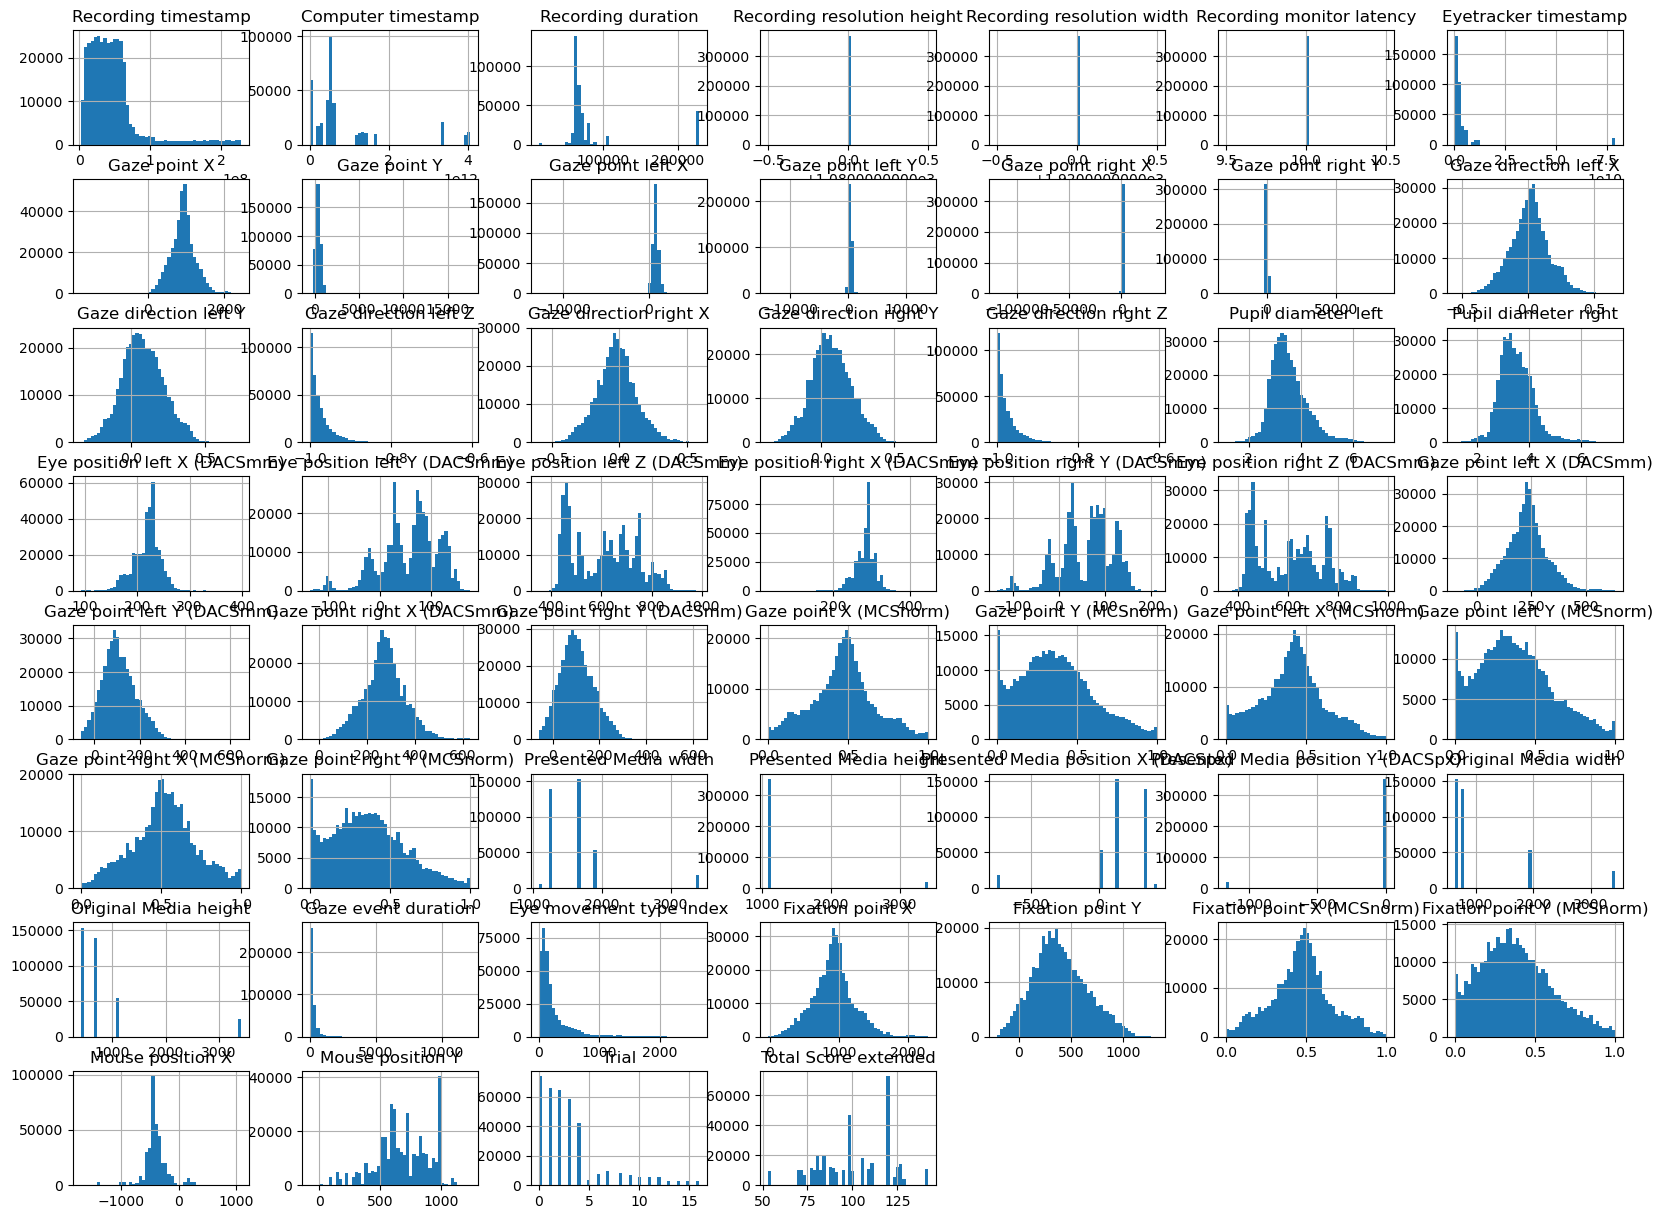

In [85]:
all_data.hist(bins=50, figsize=(20,15))

This histogram plot shows that in some cases data is dtricktly skewed and in some cases it is syymetrical. We can also see some irregular spike, this shows us that data needs further preprocessing.

In [86]:
import pandas as pd

# Group by 'participant_name' and calculate the sum of 'recording_duration'
grouped = all_data.groupby('Participant name').agg({'Recording duration': 'sum'})

# Define a custom aggregation function to select the first value from an array
select_first = lambda x: x.iloc[0]

grouped['Gaze event duration'] = all_data.groupby('Participant name').agg({'Gaze event duration': 'sum'})

# Group by 'Participant name' and apply the custom aggregation function to 'Total Score Extended' column
grouped['Total Score Extended'] = all_data.groupby('Participant name')['Total Score extended'].agg(select_first)

# Reset the index to make 'Participant name' a regular column
grouped = grouped.reset_index()

# Drop duplicate rows of 'Participant name'
grouped = grouped.drop_duplicates(subset='Participant name', keep='first')

# Sort the DataFrame based on 'Total Score Extended' column in descending order
grouped = grouped.sort_values(by='Total Score Extended', ascending=False)

# Optional: Reset the index to have a consecutive integer index
grouped = grouped.reset_index(drop=True)

# 'grouped' DataFrame now contains unique rows with sum of recording_duration for each participant
grouped

,Participant name,Recording duration,Gaze event duration,Total Score Extended
0,Participant20,731855798,2582441.0,142
1,Participant14,316780210,442747.0,128
2,Participant2,2737071859,1750951.0,127
3,Participant22,817801632,1440758.0,125
4,Participant12,358959781,1597511.0,124
5,Participant24,950433878,1415793.0,120
6,Participant4,3452918165,2750460.0,120
7,Participant6,4337838274,5014937.0,119
8,Participant18,434794781,2580281.0,111
9,Participant26,596340135,2241263.0,111


We have created a new df that has sum of Recording duration and	Gaze event duration for each participant as well as their extended score.

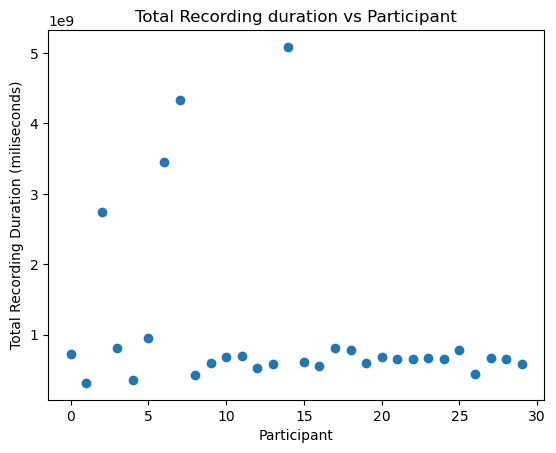

In [87]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped.index, grouped['Recording duration'])
plt.xlabel('Participant')
plt.ylabel('Total Recording Duration (miliseconds)')
plt.title('Total Recording duration vs Participant')
plt.show()


In this plot we can observe that majority of the participant took almost similar total duration to perform the activity, some outliers can also be observed.

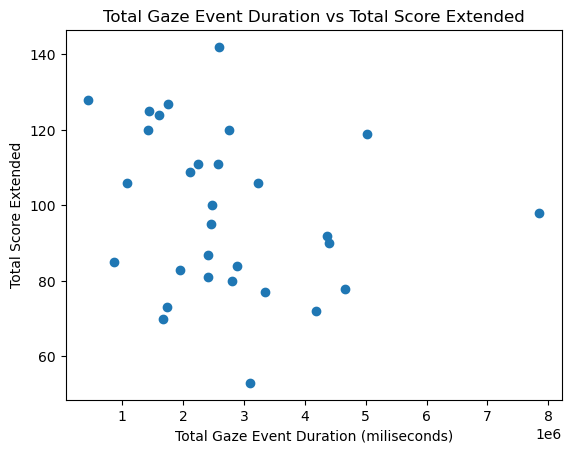

In [88]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped['Gaze event duration'], grouped['Total Score Extended'])
plt.xlabel('Total Gaze Event Duration (miliseconds)')
plt.ylabel('Total Score Extended')
plt.title('Total Gaze Event Duration vs Total Score Extended')
plt.show()

We can observe a ceiling effect on Total Gaze Event Duration vs Total Score Extended. the score is increasing as total gaze duraion is increasing and after duration reaches 3e^6 it started decreasing, this suggest that relationship between them is non linear.

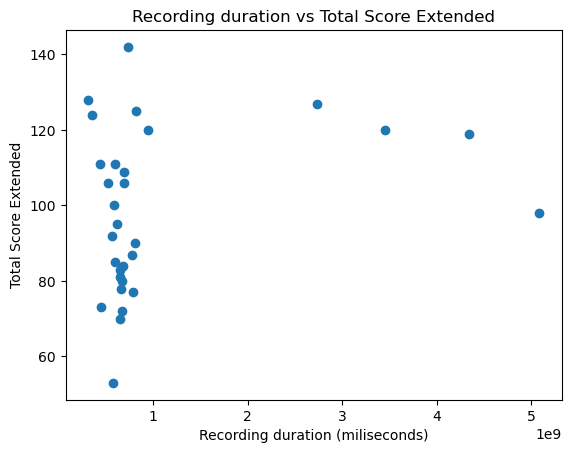

In [89]:
import matplotlib.pyplot as plt

# Plot 'Recording duration' vs 'Total Score Extended'
plt.scatter(grouped['Recording duration'], grouped['Total Score Extended'])
plt.xlabel('Recording duration (miliseconds)')
plt.ylabel('Total Score Extended')
plt.title('Recording duration vs Total Score Extended')
plt.show()


We can observe an irregular behaviour of score with duration, it is dropping and rising within the first quartile of duration. Again this is non linear.

In [90]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

print("nulls:",all_data.isnull().sum())

nulls: Recording timestamp        0
Computer timestamp         0
Sensor                     0
Project name               0
Export date                0
                        ... 
Mouse position X        4817
Mouse position Y        4817
Trial                      0
Participant name           0
Total Score extended       0
Length: 72, dtype: int64


In [91]:
# perform one-hot encoding
one_hot = pd.get_dummies(all_data['Eye movement type'])

# concatenate the one-hot encoded columns to the original dataframe
all_data = pd.concat([all_data, one_hot], axis=1)

# drop the original categorical column
all_data.drop('Eye movement type', axis=1, inplace=True)

all_data_copy = all_data

Performing one hot encoding on **Eye movement type** because based it might have some important information and we need to perform correalation on these as well.

In [92]:
# Compute correlation matrix
corr_matrix = all_data.corr()

# Extract correlation coefficients for the score column
score_corr = corr_matrix['Total Score extended']
print(score_corr)

Recording timestamp                    0.255722
Computer timestamp                    -0.395227
Recording duration                     0.328876
Recording resolution height                 NaN
Recording resolution width                  NaN
Recording monitor latency                   NaN
Eyetracker timestamp                  -0.159418
Gaze point X                           0.031505
Gaze point Y                          -0.035451
Gaze point left X                      0.047099
Gaze point left Y                     -0.041659
Gaze point right X                     0.034524
Gaze point right Y                    -0.064828
Gaze direction left X                  0.140493
Gaze direction left Y                 -0.116157
Gaze direction left Z                 -0.101759
Gaze direction right X                 0.083711
Gaze direction right Y                -0.110693
Gaze direction right Z                -0.106078
Pupil diameter left                   -0.220492
Pupil diameter right                  -0

We can observe that corelation matrix is majorly negative and not showing any strong correlation of differnt columns with Total Score Extended.

In [93]:
numeric_cols = all_data.select_dtypes(include=['float64', 'int64','uint8']).columns.tolist()
df_numeric = all_data[numeric_cols].copy()
df_numeric = df_numeric.fillna(0)

Selecting all the numeric columns so we can normalize it by filling nans with 0 to perform regressor feature extraction and PCA to extract some features.

In [94]:
# Create the scaler object
scaler = MinMaxScaler()

# Fit and transform the data
df_scaled = scaler.fit_transform(df_numeric)

# Convert the scaled data back to a DataFrame
df_normalized = pd.DataFrame(df_scaled, columns=df_numeric.columns)


Normalizing the data so we have everything scaled within a range.

In [95]:
y = df_normalized['Total Score extended']
X = df_normalized.drop(['Total Score extended'], axis=1)

In [96]:
# Fit the decision tree regressor to the data
clf = DecisionTreeRegressor()
clf.fit(X, y)

# Calculate feature importances
importances = clf.feature_importances_
importances

array([ 5.41731909e-06,  4.58397846e-01,  1.12516653e-02,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  1.81610472e-01,  1.95152020e-14,
        2.62263331e-16,  2.55404451e-14,  9.50182426e-15,  1.14558987e-14,
        1.95110810e-14,  7.96244368e-14,  9.49279207e-14,  1.70840839e-13,
        5.53601484e-15,  3.21044763e-13,  7.37698419e-15,  3.62192337e-03,
        4.91938603e-07,  4.98360002e-03,  1.87332039e-03,  1.64861684e-02,
        2.17664673e-01,  6.08786973e-02,  8.30471669e-04,  1.22103943e-14,
        1.19912391e-14,  9.37863324e-14,  4.26074413e-14,  2.08401187e-14,
        8.70022660e-13,  2.45142274e-13,  1.77867362e-14, -4.86376752e-16,
        1.34387340e-17,  2.53169922e-03, -4.63515615e-19, -3.72743807e-18,
        0.00000000e+00,  2.50518242e-02,  1.45005066e-02,  2.71397478e-14,
        1.00910407e-16,  5.70539439e-16,  6.58423204e-08,  1.92684890e-16,
        1.21566264e-15,  3.11157084e-04, -5.45596505e-18, -5.21970084e-17,
       -9.50722028e-17, -

In [97]:
# Calculate feature importances
importances = clf.feature_importances_

# Convert the values to regular numbers
importances = np.round(importances * 100, decimals=2)

# Create a dictionary to map attribute names with importance values
importances_dict = {attr: imp for attr, imp in zip(X.columns, importances)}

# Print the dictionary
importances_dict

{'Recording timestamp': 0.0,
 'Computer timestamp': 45.84,
 'Recording duration': 1.13,
 'Recording resolution height': 0.0,
 'Recording resolution width': 0.0,
 'Recording monitor latency': 0.0,
 'Eyetracker timestamp': 18.16,
 'Gaze point X': 0.0,
 'Gaze point Y': 0.0,
 'Gaze point left X': 0.0,
 'Gaze point left Y': 0.0,
 'Gaze point right X': 0.0,
 'Gaze point right Y': 0.0,
 'Gaze direction left X': 0.0,
 'Gaze direction left Y': 0.0,
 'Gaze direction left Z': 0.0,
 'Gaze direction right X': 0.0,
 'Gaze direction right Y': 0.0,
 'Gaze direction right Z': 0.0,
 'Pupil diameter left': 0.36,
 'Pupil diameter right': 0.0,
 'Eye position left X (DACSmm)': 0.5,
 'Eye position left Y (DACSmm)': 0.19,
 'Eye position left Z (DACSmm)': 1.65,
 'Eye position right X (DACSmm)': 21.77,
 'Eye position right Y (DACSmm)': 6.09,
 'Eye position right Z (DACSmm)': 0.08,
 'Gaze point left X (DACSmm)': 0.0,
 'Gaze point left Y (DACSmm)': 0.0,
 'Gaze point right X (DACSmm)': 0.0,
 'Gaze point right Y (D

Here we can see that eye position right X and Y are showing some significant numbers, among the columns that are useful according to the domain knowledge.

# PCA

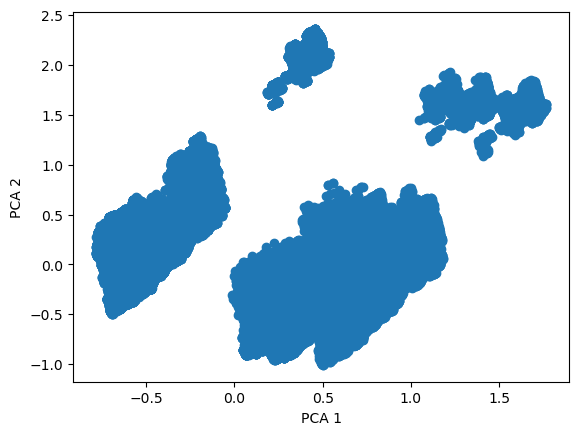

In [98]:
# One-hot encode categorical variables
data_encoded = df_normalized

# Separate target variable
y = df_normalized['Total Score extended']
X = df_normalized.drop(['Total Score extended'], axis=1)

# Perform PCA
pca = PCA()
pca.fit(df_scaled)

# Choose the number of components to keep
variance_ratio = pca.explained_variance_ratio_
n_components = len(variance_ratio[variance_ratio > 0.01])

# Transform the data to reduced dimension space
df_pca = pca.transform(df_scaled)[:, :n_components]

# Visualize the data
plt.scatter(df_pca[:, 0], df_pca[:, 1])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.show()

In [99]:
#Extract the most important features
components = pd.DataFrame(pca.components_)
most_important = components.abs().max(axis=0).sort_values(ascending=False)

# Create a dictionary to map feature indices to column names
feature_map = dict(zip(range(len(X.columns)), X.columns))

# Get the column names and loading scores of the top 10 most important features
top_features = [(feature_map[i], score) for i, score in enumerate(most_important[:-1])]

# Sort the top features by loading score in descending order
top_features = sorted(top_features, key=lambda x: x[1], reverse=True)

# Print the top 10 most important features with their corresponding column names and loading scores
for i, (feature, score) in enumerate(top_features):
    print(f"{i+1}. {feature}: {score:.3f}")


1. Recording timestamp: 0.984
2. Computer timestamp: 0.973
3. Recording duration: 0.972
4. Recording resolution height: 0.971
5. Recording resolution width: 0.962
6. Recording monitor latency: 0.954
7. Eyetracker timestamp: 0.886
8. Gaze point X: 0.883
9. Gaze point Y: 0.823
10. Gaze point left X: 0.743
11. Gaze point left Y: 0.718
12. Gaze point right X: 0.707
13. Gaze point right Y: 0.707
14. Gaze direction left X: 0.705
15. Gaze direction left Y: 0.693
16. Gaze direction left Z: 0.693
17. Gaze direction right X: 0.691
18. Gaze direction right Y: 0.653
19. Gaze direction right Z: 0.650
20. Pupil diameter left: 0.649
21. Pupil diameter right: 0.643
22. Eye position left X (DACSmm): 0.607
23. Eye position left Y (DACSmm): 0.606
24. Eye position left Z (DACSmm): 0.606
25. Eye position right X (DACSmm): 0.605
26. Eye position right Y (DACSmm): 0.602
27. Eye position right Z (DACSmm): 0.596
28. Gaze point left X (DACSmm): 0.584
29. Gaze point left Y (DACSmm): 0.574
30. Gaze point right X 

Here we have list of all the useful features and their contributions identified by PCA. At this point we have regressor identified columns as well as PCA ones, now we will apply our domain knowledge to filter and extract the useful features.

# Preparing the data

In [100]:
import pandas as pd

# Group the data by Participant and Trial, and find the mode of each group
# df_mode = all_data.groupby(['Participant name', 'Trial']).apply(lambda x: x.mode().iloc[0])

def aggregate_func(group):
    return group.mode().iloc[0]

# Groupby 'Participant' and 'Trial', and apply the custom aggregation function
result = all_data.groupby(['Participant name', 'Trial']).apply(aggregate_func).reset_index(drop=True)

result

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,...,Fixation point Y (MCSnorm),Mouse position X,Mouse position Y,Trial,Participant name,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,4394847,2575955327,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,0.3657,-190.0,600.0,0.0,Participant10,100.0,0.0,1.0,0.0,0.0
1,5932428,2659237147,Eye Tracker,Participant10,29.10.2020,Recording2,29.10.2020,29.10.2020,14:03:37.093,13:03:37.093,...,0.5250,-398.0,658.0,1.0,Participant10,100.0,0.0,1.0,0.0,0.0
2,7323413,2823494812,Eye Tracker,Participant10,29.10.2020,Recording3,29.10.2020,29.10.2020,14:06:19.967,13:06:19.967,...,0.4895,-208.0,789.0,2.0,Participant10,100.0,0.0,1.0,0.0,0.0
3,2414233,2896554812,Eye Tracker,Participant10,29.10.2020,Recording4,29.10.2020,29.10.2020,14:07:38.020,13:07:38.020,...,0.4291,-305.0,696.0,3.0,Participant10,100.0,0.0,1.0,0.0,0.0
4,6718738,2023148355,Eye Tracker,Participant0012,29.10.2020,Recording1,29.10.2020,29.10.2020,15:01:33.357,14:01:33.357,...,0.2680,-459.0,811.0,0.0,Participant12,124.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,17657166,520737975462,Eye Tracker,Control group experiment,20.10.2020,Recording13,07.10.2020,07.10.2020,16:09:00.157,14:09:00.157,...,0.0087,-355.0,528.0,12.0,Participant8,98.0,0.0,1.0,0.0,0.0
138,5334772,9863855454,Eye Tracker,Control group experiment,20.10.2020,Recording14,20.10.2020,20.10.2020,14:42:37.907,12:42:37.907,...,0.2974,-208.0,511.0,13.0,Participant8,98.0,0.0,1.0,0.0,0.0
139,3577179,9954428641,Eye Tracker,Control group experiment,20.10.2020,Recording15,20.10.2020,20.10.2020,14:44:10.337,12:44:10.337,...,0.1301,-338.0,423.0,14.0,Participant8,98.0,0.0,1.0,0.0,0.0
140,5441353,10077944171,Eye Tracker,Control group experiment,20.10.2020,Recording16,20.10.2020,20.10.2020,14:46:12.080,12:46:12.080,...,0.0879,-923.0,222.0,15.0,Participant8,98.0,0.0,1.0,0.0,0.0


In [101]:
count = result.groupby('Participant name').size().reset_index(name='Count')

print(count)

   Participant name  Count
0     Participant10      4
1     Participant12      4
2     Participant14      4
3     Participant16      4
4     Participant18      4
5      Participant2      4
6     Participant20      4
7     Participant22      4
8     Participant24      4
9     Participant26      3
10    Participant28      4
11    Participant30      4
12    Participant32      3
13    Participant34      4
14    Participant36      4
15    Participant38      4
16     Participant4      8
17    Participant40      4
18    Participant42      4
19    Participant44      4
20    Participant46      4
21    Participant48      4
22    Participant50      4
23    Participant52      4
24    Participant54      4
25    Participant56      4
26    Participant58      4
27     Participant6     12
28    Participant60      4
29     Participant8     16


Since we have multiple trials for each participant and rows are almost identical, we are extracting mode row, i.e. the one mostly repeated. Extracting one row for each trial and for each participant.

In [102]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assume 'Trial' column represents time periods

# Sort the dataframe by 'Trial'
result = result.sort_values('Trial')
result

,Recording timestamp,Computer timestamp,Sensor,Project name,Export date,Recording name,Recording date,Recording date UTC,Recording start time,Recording start time UTC,...,Fixation point Y (MCSnorm),Mouse position X,Mouse position Y,Trial,Participant name,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,4394847,2575955327,Eye Tracker,Participant10,29.10.2020,Recording1,29.10.2020,29.10.2020,14:02:15.450,13:02:15.450,...,0.3657,-190.0,600.0,0.0,Participant10,100.0,0.0,1.0,0.0,0.0
32,4794663,613406823542,Eye Tracker,Participant0024,10.02.2021,Recording1,10.02.2021,10.02.2021,13:28:22.410,12:28:22.410,...,0.1029,-433.0,982.0,0.0,Participant24,120.0,0.0,0.0,0.0,0.0
39,3799552,1224993592514,Eye Tracker,Participant0028,17.02.2021,Recording1,17.02.2021,17.02.2021,15:21:21.223,14:21:21.223,...,0.0588,-477.0,731.0,0.0,Participant28,109.0,0.0,1.0,0.0,0.0
43,7602056,1300217752103,Eye Tracker,Participant0030,18.02.2021,Recording1,18.02.2021,18.02.2021,12:14:59.683,11:14:59.683,...,0.5968,-399.0,971.0,0.0,Participant30,77.0,0.0,1.0,0.0,0.0
47,5875122,597912832,Eye Tracker,Participant0032,10.03.2021,Recording1,10.03.2021,10.03.2021,10:37:02.127,09:37:02.127,...,0.5797,-410.0,83.0,0.0,Participant32,85.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,17657166,520737975462,Eye Tracker,Control group experiment,07.10.2020,Recording13,07.10.2020,07.10.2020,16:09:00.157,14:09:00.157,...,0.0087,-355.0,528.0,12.0,Participant6,119.0,0.0,1.0,0.0,0.0
138,5334772,9863855454,Eye Tracker,Control group experiment,20.10.2020,Recording14,20.10.2020,20.10.2020,14:42:37.907,12:42:37.907,...,0.2974,-208.0,511.0,13.0,Participant8,98.0,0.0,1.0,0.0,0.0
139,3577179,9954428641,Eye Tracker,Control group experiment,20.10.2020,Recording15,20.10.2020,20.10.2020,14:44:10.337,12:44:10.337,...,0.1301,-338.0,423.0,14.0,Participant8,98.0,0.0,1.0,0.0,0.0
140,5441353,10077944171,Eye Tracker,Control group experiment,20.10.2020,Recording16,20.10.2020,20.10.2020,14:46:12.080,12:46:12.080,...,0.0879,-923.0,222.0,15.0,Participant8,98.0,0.0,1.0,0.0,0.0


Here, we are sorting the rows on the basis of trial id so we can treat this problem as time series. As this was highlighted in the feedback that this should be treated as time series problem.

In [103]:
# Define the useful columns and dropping the rest
cols_to_keep = ['Recording duration', 'Pupil diameter left', 'Pupil diameter right', 'Gaze event duration', 'EyesNotFound','Fixation','Saccade','Unclassified','Gaze event duration', 'Gaze point X', 'Gaze point Y','Gaze point left X','Gaze point left Y','Gaze point right X','Gaze point right Y','Gaze direction left X','Gaze direction left Y','Gaze direction left Z','Gaze direction right X','Gaze direction right Y','Gaze direction right Z','Total Score extended','Participant name']
all_data = result.drop(columns=[col for col in result.columns if col not in cols_to_keep])

Here, we have idenfitifed and filtered out the useful features. The selection is based on their contribution as well as domain knowledge.

In [104]:
all_data

,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,...,Gaze direction right Z,Pupil diameter left,Pupil diameter right,Gaze event duration,Participant name,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,64561.0,978.0,279.0,953.0,250.0,978.0,300.0,0.05909,-0.03426,-0.99829,...,-0.99989,3.23,3.30,17.0,Participant10,100.0,0.0,1.0,0.0,0.0
32,90961.0,906.0,132.0,841.0,67.0,992.0,184.0,-0.01440,0.06594,-0.99772,...,-0.92432,4.28,3.60,17.0,Participant24,120.0,0.0,0.0,0.0,0.0
39,66546.0,1132.0,-104.0,1268.0,365.0,927.0,-80.0,0.04648,0.25365,-0.96618,...,-0.87210,3.99,4.06,17.0,Participant28,109.0,0.0,1.0,0.0,0.0
43,66999.0,642.0,135.0,538.0,169.0,773.0,7.0,-0.11380,0.41279,-0.90369,...,-0.83626,6.05,4.85,17.0,Participant30,77.0,0.0,1.0,0.0,0.0
47,65543.0,851.0,671.0,611.0,722.0,1067.0,639.0,-0.10110,0.37890,-0.94467,...,-0.94810,4.15,5.08,17.0,Participant32,85.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,79029.0,1089.0,79.0,960.0,524.0,1204.0,536.0,0.02718,0.00497,-0.99916,...,-0.99887,3.54,3.94,17.0,Participant6,119.0,0.0,1.0,0.0,0.0
138,65557.0,1053.0,475.0,994.0,481.0,833.0,604.0,-0.25034,-0.03531,-0.96886,...,-0.88974,4.09,4.07,17.0,Participant8,98.0,0.0,1.0,0.0,0.0
139,63827.0,656.0,85.0,983.0,77.0,1029.0,373.0,0.28365,-0.17458,-0.99689,...,-0.98623,4.24,4.11,17.0,Participant8,98.0,0.0,1.0,0.0,0.0
140,65681.0,683.0,-27.0,643.0,509.0,724.0,448.0,-0.17833,-0.02789,-0.97619,...,-0.91863,3.94,3.96,17.0,Participant8,98.0,0.0,1.0,0.0,0.0


In [105]:
all_data['Participant name'] = all_data['Participant name'].str.extract(r'(\d+)')


In [106]:
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

print("nulls:",all_data.isnull().sum())

pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

nulls: 0
Recording duration        0
Gaze point X              0
Gaze point Y              0
Gaze point left X         0
Gaze point left Y         0
Gaze point right X        0
Gaze point right Y        0
Gaze direction left X     0
Gaze direction left Y     0
Gaze direction left Z     0
Gaze direction right X    0
Gaze direction right Y    0
Gaze direction right Z    0
Pupil diameter left       0
Pupil diameter right      0
Gaze event duration       0
Participant name          0
Total Score extended      0
EyesNotFound              0
Fixation                  0
Saccade                   0
Unclassified              0
dtype: int64


In [107]:
# Create the scaler object
scalerSelectedCols = MinMaxScaler()

# Fit and transform the data
df_scaled = scalerSelectedCols.fit_transform(all_data)

# Convert the scaled data back to a DataFrame
df_normalized = pd.DataFrame(df_scaled, columns=all_data.columns)
df_normalized


,Recording duration,Gaze point X,Gaze point Y,Gaze point left X,Gaze point left Y,Gaze point right X,Gaze point right Y,Gaze direction left X,Gaze direction left Y,Gaze direction left Z,...,Gaze direction right Z,Pupil diameter left,Pupil diameter right,Gaze event duration,Participant name,Total Score extended,EyesNotFound,Fixation,Saccade,Unclassified
0,0.235334,0.557845,0.326235,0.533981,0.341424,0.554498,0.404103,0.622719,0.302301,0.010515,...,0.000611,0.303704,0.334917,0.002232,0.137931,0.528090,0.0,1.0,0.0,0.0
1,0.358514,0.500792,0.201022,0.443366,0.193366,0.566609,0.300624,0.520664,0.425544,0.014041,...,0.462163,0.562963,0.406176,0.002232,0.379310,0.752809,0.0,0.0,0.0,0.0
2,0.244596,0.679873,0.000000,0.788835,0.434466,0.510381,0.065120,0.605208,0.656421,0.209130,...,0.781103,0.491358,0.515439,0.002232,0.448276,0.629213,0.0,1.0,0.0,0.0
3,0.246709,0.291601,0.203578,0.198220,0.275890,0.377163,0.142730,0.382627,0.852158,0.595658,...,1.000000,1.000000,0.703088,0.002232,0.482759,0.269663,0.0,1.0,0.0,0.0
4,0.239916,0.457211,0.660136,0.257282,0.723301,0.631488,0.706512,0.400264,0.810474,0.342179,...,0.316924,0.530864,0.757720,0.002232,0.517241,0.359551,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,0.302840,0.645800,0.155877,0.539644,0.563107,0.750000,0.614630,0.578406,0.350553,0.005134,...,0.006841,0.380247,0.486936,0.002232,0.068966,0.741573,0.0,1.0,0.0,0.0
138,0.239981,0.617274,0.493186,0.567152,0.528317,0.429066,0.675290,0.193015,0.301010,0.192553,...,0.673365,0.516049,0.517815,0.002232,0.103448,0.505618,0.0,1.0,0.0,0.0
139,0.231909,0.302694,0.160988,0.558252,0.201456,0.598616,0.469224,0.934565,0.129712,0.019175,...,0.084041,0.553086,0.527316,0.002232,0.103448,0.505618,0.0,1.0,0.0,0.0
140,0.240560,0.324089,0.065588,0.283172,0.550971,0.334775,0.536128,0.293015,0.310136,0.147213,...,0.496916,0.479012,0.491686,0.002232,0.103448,0.505618,0.0,1.0,0.0,0.0


# Training and Evaluating the Model

In [108]:
from sklearn.model_selection import GroupShuffleSplit

# Assuming your DataFrame is called 'df_normalized' and the target variable is called 'y'
X = df_normalized.drop('Total Score extended', axis=1)
y = df_normalized['Total Score extended']
groups = df_normalized['Participant name']  # Specify the group variable

# Create an instance of GroupShuffleSplit with the desired number of splits and test set size
n_splits = 1 
test_size = 0.3  # You can adjust this value as needed
group_shuffle_split = GroupShuffleSplit(n_splits=n_splits, test_size=test_size, random_state=42)

# Iterate over the group-wise splits
for train_index, test_index in group_shuffle_split.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    # Use X_train, y_train for training and X_test, y_test for testing
    # You can also print the shapes of the resulting arrays for verification
    print("Shape of X_train:", X_train.shape)
    print("Shape of y_train:", y_train.shape)
    print("Shape of X_test:", X_test.shape)
    print("Shape of y_test:", y_test.shape)


Shape of X_train: (99, 21)
Shape of y_train: (99,)
Shape of X_test: (43, 21)
Shape of y_test: (43,)


Here, we have normalized and splitted the data into train test. We will be using this split for our model training.

In [109]:
from sklearn.model_selection import cross_val_score, GroupKFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# create an instance of the Random Forest Regressor class
rf = RandomForestRegressor(n_estimators=100, random_state=42)

# define the number of folds for cross-validation
num_folds = 10

# create an instance of GroupKFold with the number of folds
gkf = GroupKFold(n_splits=num_folds)

# perform group k-fold cross-validation on the model
scores = -cross_val_score(rf, X, y, cv=gkf, groups=df_normalized['Participant name'], scoring='neg_mean_squared_error', n_jobs=-1)

variance = np.var(y)

# Create a DataFrame to store the MSE and R2 scores
df_scores_D2 = pd.DataFrame({'R2 score': 1 - (scores/variance),'MSE':scores})
# compute the mean and standard deviation of the scores
mean_score = scores.mean()
std_score = scores.std()

print("Mean Squared Error (MSE) on group k-fold cross-validation: {:.3f} +/- {:.3f}".format(mean_score, std_score))
df_scores_D2

Mean Squared Error (MSE) on group k-fold cross-validation: 0.032 +/- 0.024


,R2 score,MSE
0,0.180893,0.042557
1,0.906048,0.004881
2,0.382119,0.032102
3,0.428237,0.029706
4,0.706437,0.015252
5,0.839349,0.008347
6,-0.310747,0.068100
7,-0.559502,0.081024
8,0.651937,0.018084
9,0.628529,0.019300


Now, we are cross validating the rando forest regressor on 10 folds with group k fold method so we can have different participant each time when training and testing and also grouping them together, this will show us the actual performance of the model and we can handle the data leakage. Please note that we I have again changed the evaluation type and now this will be treated like a normal regression problem instead of a timeseries regression prblem as it does not make sense.

Here, we have validated the randomforest regressor with 10 folds. The mean of 10 fold MSE is **0.032** which is very low and this suggest that the model is quite accurate. We also have standard deviation of MSE on cross-validated folds which is **0.024**, again low deviation suggest the model is quite stable.

In [110]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create an instance of the Random Forest Regressor class
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)

# Fit the model to the training data
rf.fit(X_train, y_train)

# Make predictions on the test data
y_pred = rf.predict(X_test)

# Compute the mean squared error on the test set
mse = mean_squared_error(y_test, y_pred)

# Compute the R2 score on the test set
r2 = r2_score(y_test, y_pred)

# Display the mean squared error (MSE) and R2 score
print("Mean Squared Error (MSE) on test set: {:.3f}".format(mse))
print("R2 Score on test set: {:.3f}".format(r2))


Mean Squared Error (MSE) on test set: 0.007
R2 Score on test set: 0.832


To our surprise we can see the model is giving the MSE of 0.007 and R2 score of 0.832 which suggest the model's accuracy is 83.2%. Please note that we have already dropped the duplicates and filled the nans so this possibly is not the case of over fitting.

# Predicting

In [111]:
def predict(test):
    testDf = test.copy()
    y_pred = rf.predict(testDf)
    testDf['Total Score extended'] = y_pred
    y_pred_denormalized = scalerSelectedCols.inverse_transform(testDf)
    pred = pd.DataFrame(y_pred_denormalized)
    print("Empathy Score",pred.iloc[0][16])
    # Calculate feature importances
    importances = rf.feature_importances_

    # Convert the values to regular numbers
    importances = np.round(importances * 100, decimals=3)

    # Create a dictionary to map attribute names with importance values
    importances_dict = {attr: imp for attr, imp in zip(X.columns, importances)}

    # Print the dictionary
    print("\nThe Explaination for the Score: below we have a dictionary with contribution score where, 100% means mostly contributed:")
    return importances_dict
predict(X_test)

Empathy Score 6.0

The Explaination for the Score: below we have a dictionary with contribution score where, 100% means mostly contributed:


{'Recording duration': 1.756,
 'Gaze point X': 1.548,
 'Gaze point Y': 2.108,
 'Gaze point left X': 2.092,
 'Gaze point left Y': 1.142,
 'Gaze point right X': 3.073,
 'Gaze point right Y': 1.026,
 'Gaze direction left X': 1.475,
 'Gaze direction left Y': 0.508,
 'Gaze direction left Z': 1.305,
 'Gaze direction right X': 0.748,
 'Gaze direction right Y': 0.711,
 'Gaze direction right Z': 0.63,
 'Pupil diameter left': 2.0,
 'Pupil diameter right': 1.364,
 'Gaze event duration': 0.382,
 'Participant name': 77.323,
 'EyesNotFound': 0.0,
 'Fixation': 0.809,
 'Saccade': 0.0,
 'Unclassified': 0.0}

# Dataset Comparison

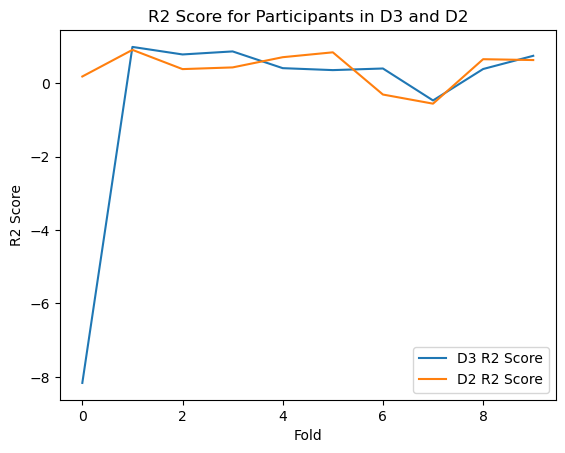

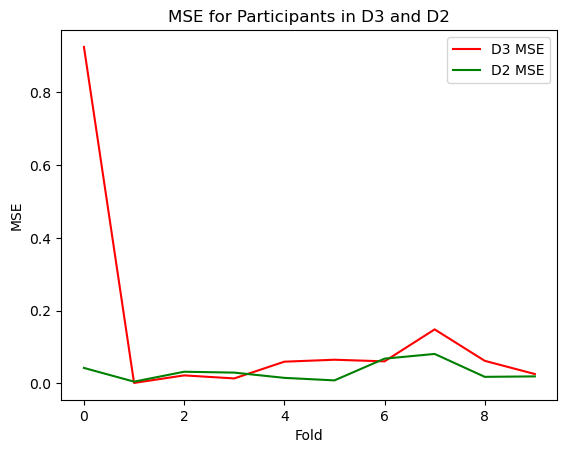

In [112]:
import matplotlib.pyplot as plt
import pandas as pd

# Create a figure for R2 score plot
fig1, ax1 = plt.subplots()
# Plot R2 score for D3
df_scores_D3.plot(y='R2 score', ax=ax1, label='D3 R2 Score', kind='line')
# Plot R2 score for D2
df_scores_D2.plot(y='R2 score', ax=ax1, label='D2 R2 Score', kind='line')
# Set the title, labels, and legend for the R2 score plot
ax1.set_title('R2 Score for Participants in D3 and D2')
ax1.set_xlabel('Fold')
ax1.set_ylabel('R2 Score')
ax1.legend()

# Create a figure for MSE plot
fig2, ax2 = plt.subplots()
# Plot MSE for D3
df_scores_D3.plot(y='MSE', ax=ax2, label='D3 MSE', kind='line', color='red')
# Plot MSE for D2
df_scores_D2.plot(y='MSE', ax=ax2, label='D2 MSE', kind='line', color='green')
# Set the title, labels, and legend for the MSE plot
ax2.set_title('MSE for Participants in D3 and D2')
ax2.set_xlabel('Fold')
ax2.set_ylabel('MSE')
ax2.legend()

# Show the plots
plt.show()


Here we have plotted the MSE and R2 score on each fold and we can clearly see that dataset II performed way better than dataset III. This is the reason we have selected this dataset.